In [1]:
!pip install polars


In [2]:
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
from sklearn.preprocessing import StandardScale
import umap
from sklearn.cluster import AgglomerativeClustering
import hdbscan
import numpy as np
import os

df_nl = pl.read_parquet("/content/elfen_features_nl.parquet")


In [4]:
print("Stats:\n", df_nl.describe())

Stats:
 shape: (9, 207)
┌────────────┬───────────┬───────────┬───────────┬───┬───────────┬──────────┬──────────┬───────────┐
│ statistic  ┆ text      ┆ raw_seque ┆ n_tokens  ┆ … ┆ n_ordinal ┆ n_fac    ┆ n_law    ┆ n_languag │
│ ---        ┆ ---       ┆ nce_lengt ┆ ---       ┆   ┆ ---       ┆ ---      ┆ ---      ┆ e         │
│ str        ┆ str       ┆ h         ┆ f64       ┆   ┆ f64       ┆ f64      ┆ f64      ┆ ---       │
│            ┆           ┆ ---       ┆           ┆   ┆           ┆          ┆          ┆ f64       │
│            ┆           ┆ f64       ┆           ┆   ┆           ┆          ┆          ┆           │
╞════════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪══════════╪══════════╪═══════════╡
│ count      ┆ 3782      ┆ 3782.0    ┆ 3782.0    ┆ … ┆ 3782.0    ┆ 3782.0   ┆ 3782.0   ┆ 3782.0    │
│ null_count ┆ 0         ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0      ┆ 0.0       │
│ mean       ┆ null      ┆ 715.46351 ┆ 135.45187 ┆ … ┆ 0.152829  ┆ 

In [7]:
coded_transcript = pd.read_csv('/content/coded_transcript_10 (1).csv')

In [8]:
coded_transcript

,Unnamed: 0,speaker,party,utterance,n_utterance,n_utterances,source_doc_id,source_doc_title,Llama3_Code,Falcon_Code,Mistral_Code
0,7429,De voorzitter,NaN,Ik heropen de vergadering. Aan de orde is het ...,1,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,"Main idea: ""The meeting is opened to discuss t...",The main idea of the sentence is that the deba...,"This sentence is about opening a meeting, welc..."
1,7430,De voorzitter,NaN,We gaan beginnen met de eerste termijn van de ...,2,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,Start of parliamentary debate.<|eot_id|><|star...,We will begin by discussing the first term on ...,This sentence is about starting the first term...
2,7431,Daniëlle Jansen,NSC,Voorzitter. Ik wil u eerst meenemen in een cas...,3,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,"The main idea of this sentence is: ""Protecting...","""The Dutch government has announced that it wi...",The main idea of this text is a call to protec...
3,7432,Crijns,PVV,Mevrouw Jansen heeft eigenlijk elke keer hetze...,4,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,"""Mevrouw Jansen's speech"" or ""Registration of ...",The main idea of the sentence is that Mevrouw ...,Mevrouw Jansen repeatedly tells the same story...
4,7433,Daniëlle Jansen,NSC,Nieuw Sociaal Contract ziet de registratieplic...,5,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,Rookvrije generatie</assistant>: Rookvrije,The main idea of the sentence is that the regi...,This sentence is about a new social contract v...
...,...,...,...,...,...,...,...,...,...,...,...
3777,505,De Vos,FVD,"Nogmaals, die consensus is er niet. Ik heb ver...",506,510,nl.oorg10002.2b.2025.20242025-61-8.doc.1,Climate and Energy,"The main idea of this sentence is: ""The minist...",<human>: <human>: <human>: <human,The speaker values science and its independenc...
3778,506,De voorzitter,NaN,"Afrondend, mevrouw De Vos.",507,510,nl.oorg10002.2b.2025.20242025-61-8.doc.1,Climate and Energy,"The main idea is: ""Goodbye, Mrs. De Vos.""",The sentence describes a meeting between two p...,The sentence appears to be in Dutch and transl...
3779,507,De Vos,FVD,"Ja, tot slot. We gaan hier duidelijk niet uit ...",508,510,nl.oorg10002.2b.2025.20242025-61-8.doc.1,Climate and Energy,"The main idea of this sentence is: ""The minist...",<noinput>,The speaker defends her position based on scie...
3780,508,Erkens,VVD,De minister gaf op een aantal andere vlakken a...,509,510,nl.oorg10002.2b.2025.20242025-61-8.doc.1,Climate and Energy,"""What else can be done?"" or ""What more can be ...",The Minister of Energy is now speaking. Minis...,The minister focused on explaining the acceler...


In [11]:
df_elfen

,text,raw_sequence_length,n_tokens,n_sentences,tokens_per_sentence,n_characters,avg_word_length,n_types,n_long_words,n_lemmas,...,n_percent,n_work_of_art,n_quantity,n_norp,n_loc,n_event,n_ordinal,n_fac,n_law,n_language
0,Ik heropen de vergadering. Aan de orde is het ...,503,86,6,14.333333,426,4.953488,58,28,54,...,0,0,0,0,0,0,0,0,0,0
1,We gaan beginnen met de eerste termijn van de ...,171,35,2,17.500000,141,4.028571,30,9,29,...,0,0,0,0,0,0,1,0,0,0
2,Voorzitter. Ik wil u eerst meenemen in een cas...,6170,1114,78,14.282051,5182,4.651706,475,333,411,...,2,0,0,0,1,0,3,0,0,0
3,Mevrouw Jansen heeft eigenlijk elke keer hetze...,501,86,6,14.333333,426,4.953488,61,33,58,...,0,0,0,0,0,0,0,0,0,0
4,Nieuw Sociaal Contract ziet de registratieplic...,814,144,7,20.571429,681,4.729167,91,47,86,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3777,"Nogmaals, die consensus is er niet. Ik heb ver...",1658,315,21,15.000000,1375,4.365079,157,82,137,...,0,0,0,0,0,0,0,0,0,0
3778,"Afrondend, mevrouw De Vos.",26,6,3,2.000000,23,3.833333,6,2,6,...,0,0,0,0,0,0,0,0,0,0
3779,"Ja, tot slot. We gaan hier duidelijk niet uit ...",1204,235,12,19.583333,995,4.234043,128,60,120,...,0,0,0,0,0,0,3,0,0,0
3780,De minister gaf op een aantal andere vlakken a...,850,166,11,15.090909,705,4.246988,105,38,93,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_elfen = pl.read_parquet("elfen_features_nl.parquet").to_pandas()

df_transcript = pd.read_csv("/content/coded_transcript_10 (1).csv")

df_merged = pd.merge(df_transcript, df_elfen, left_on="utterance", right_on="text", how="inner")


In [13]:
df_merged

,Unnamed: 0,speaker,party,utterance,n_utterance,n_utterances,source_doc_id,source_doc_title,Llama3_Code,Falcon_Code,...,n_percent,n_work_of_art,n_quantity,n_norp,n_loc,n_event,n_ordinal,n_fac,n_law,n_language
0,7429,De voorzitter,NaN,Ik heropen de vergadering. Aan de orde is het ...,1,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,"Main idea: ""The meeting is opened to discuss t...",The main idea of the sentence is that the deba...,...,0,0,0,0,0,0,0,0,0,0
1,7430,De voorzitter,NaN,We gaan beginnen met de eerste termijn van de ...,2,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,Start of parliamentary debate.<|eot_id|><|star...,We will begin by discussing the first term on ...,...,0,0,0,0,0,0,1,0,0,0
2,7431,Daniëlle Jansen,NSC,Voorzitter. Ik wil u eerst meenemen in een cas...,3,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,"The main idea of this sentence is: ""Protecting...","""The Dutch government has announced that it wi...",...,2,0,0,0,1,0,3,0,0,0
3,7432,Crijns,PVV,Mevrouw Jansen heeft eigenlijk elke keer hetze...,4,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,"""Mevrouw Jansen's speech"" or ""Registration of ...",The main idea of the sentence is that Mevrouw ...,...,0,0,0,0,0,0,0,0,0,0
4,7433,Daniëlle Jansen,NSC,Nieuw Sociaal Contract ziet de registratieplic...,5,281,nl.oorg10002.2b.2025.20242025-50-11.doc.1,Invoering van een registratieplicht voor verko...,Rookvrije generatie</assistant>: Rookvrije,The main idea of the sentence is that the regi...,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6321,507,De Vos,FVD,"Ja, tot slot. We gaan hier duidelijk niet uit ...",508,510,nl.oorg10002.2b.2025.20242025-61-8.doc.1,Climate and Energy,"The main idea of this sentence is: ""The minist...",<noinput>,...,0,0,0,0,0,0,3,0,0,0
6322,508,Erkens,VVD,De minister gaf op een aantal andere vlakken a...,509,510,nl.oorg10002.2b.2025.20242025-61-8.doc.1,Climate and Energy,"""What else can be done?"" or ""What more can be ...",The Minister of Energy is now speaking. Minis...,...,0,0,0,0,0,0,0,0,0,0
6323,508,Erkens,VVD,De minister gaf op een aantal andere vlakken a...,509,510,nl.oorg10002.2b.2025.20242025-61-8.doc.1,Climate and Energy,"""What else can be done?"" or ""What more can be ...",The Minister of Energy is now speaking. Minis...,...,0,0,0,0,0,0,0,0,0,0
6324,509,De voorzitter,NaN,"Hartelijk dank aan de minister, de leden, de o...",510,510,nl.oorg10002.2b.2025.20242025-61-8.doc.1,Climate and Energy,Thank you. Main idea: Voting on motions on Mar...,"Thank you to the Minister, the leaders, the su...",...,0,0,0,1,0,0,0,0,0,0


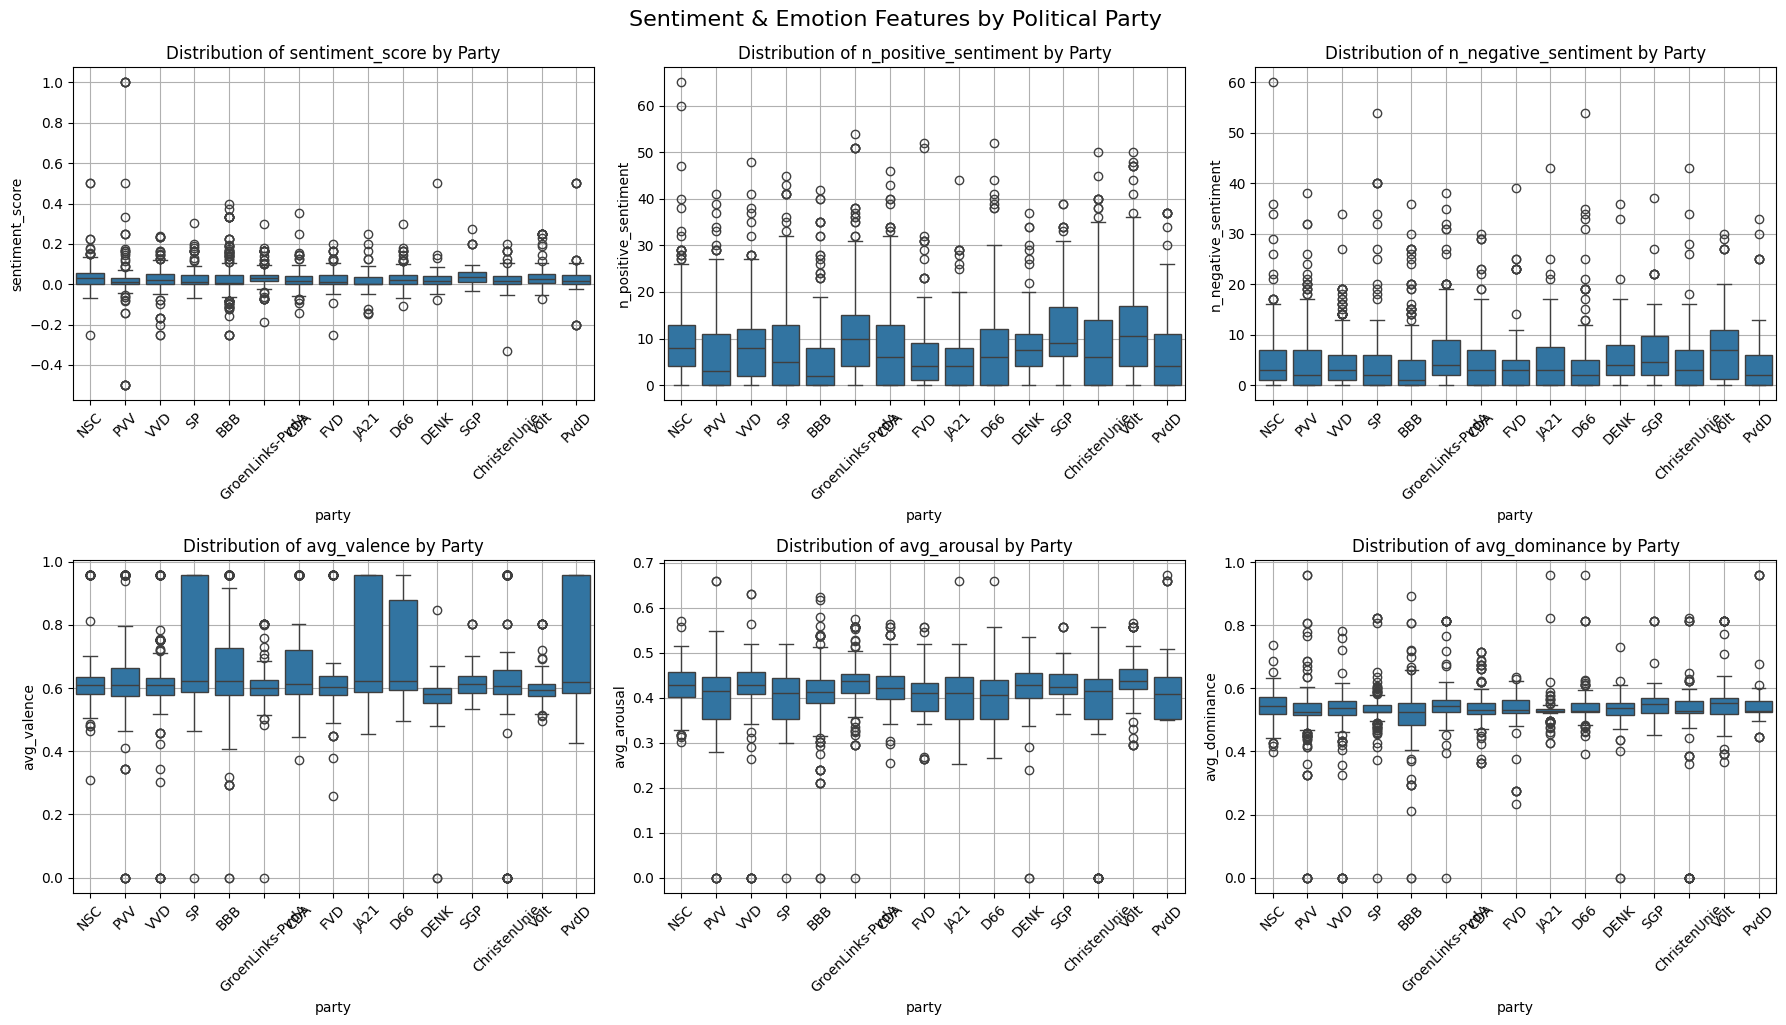

In [15]:
features = [
    "sentiment_score", "n_positive_sentiment", "n_negative_sentiment",
    "avg_valence", "avg_arousal", "avg_dominance"
]

df_filtered = df_merged.dropna(subset=["party"] + features)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(features):
    sns.boxplot(data=df_filtered, x="party", y=feature, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {feature} by Party", fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True)

plt.tight_layout()
plt.suptitle("Sentiment & Emotion Features by Political Party", fontsize=16, y=1.02)
plt.show()


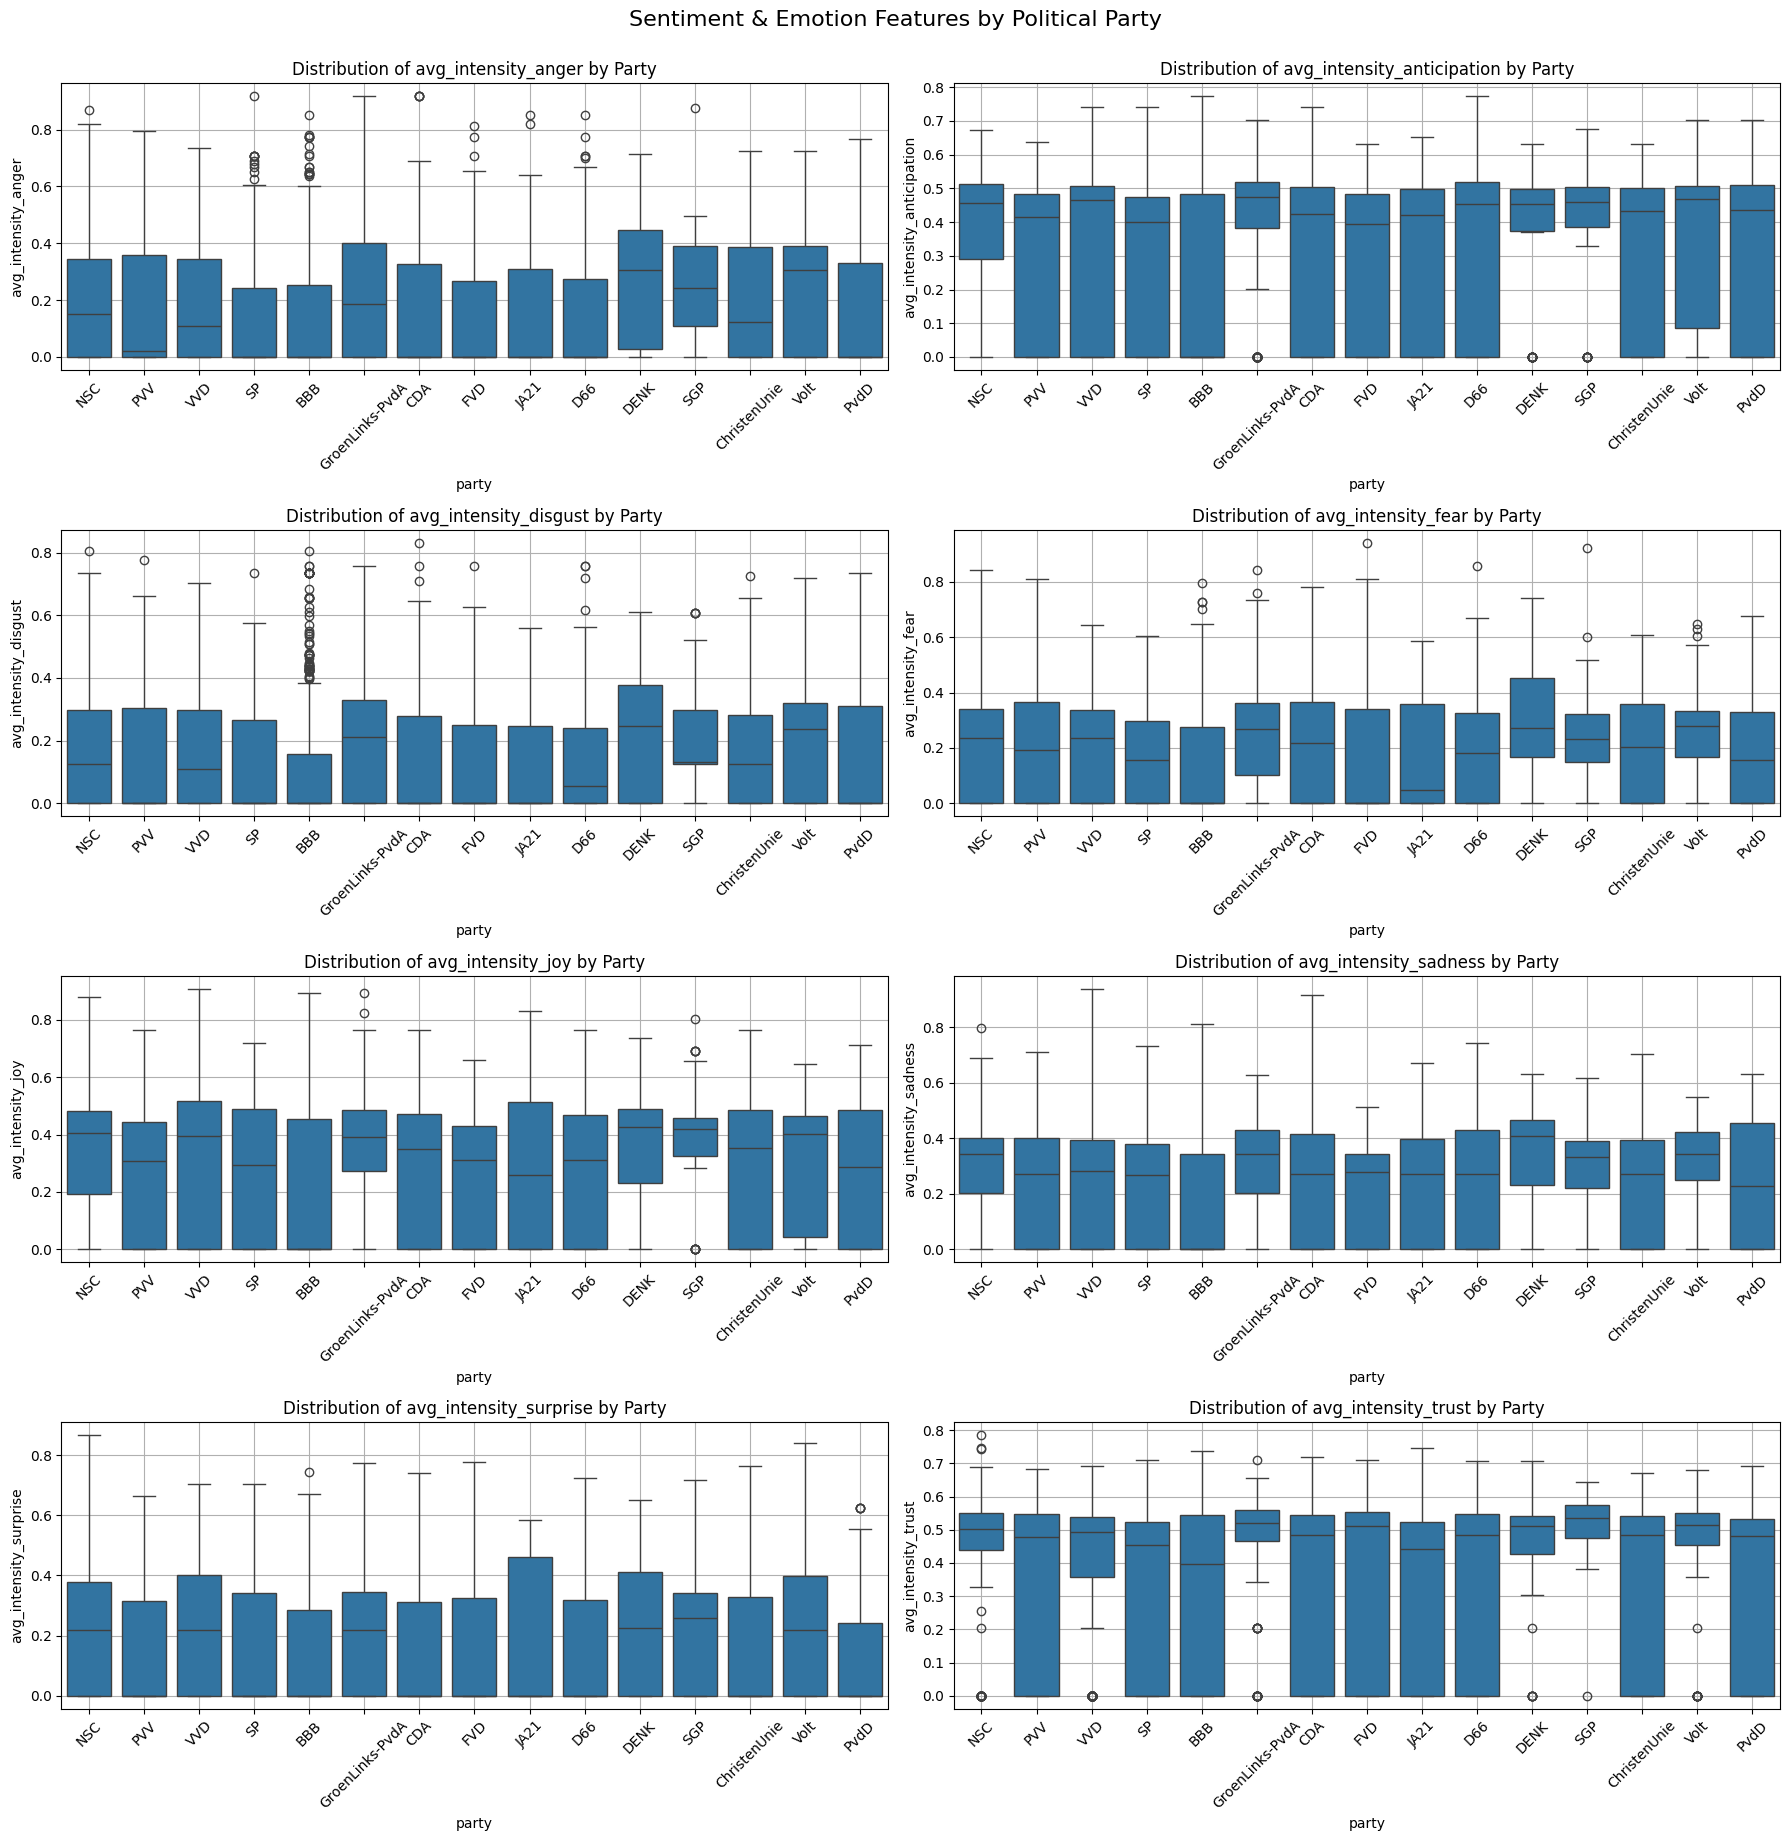

In [22]:
features = [
  'avg_intensity_anger',
 'avg_intensity_anticipation',
 'avg_intensity_disgust',
 'avg_intensity_fear',
 'avg_intensity_joy',
 'avg_intensity_sadness',
 'avg_intensity_surprise',
 'avg_intensity_trust'
]

df_filtered = df_merged.dropna(subset=["party"] + features)

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(18, 18))
axes = axes.flatten()

for idx, feature in enumerate(features):
    sns.boxplot(data=df_filtered, x="party", y=feature, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {feature} by Party", fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True)

plt.tight_layout()
plt.suptitle("Sentiment & Emotion Features by Political Party", fontsize=16, y=1.02)
plt.show()


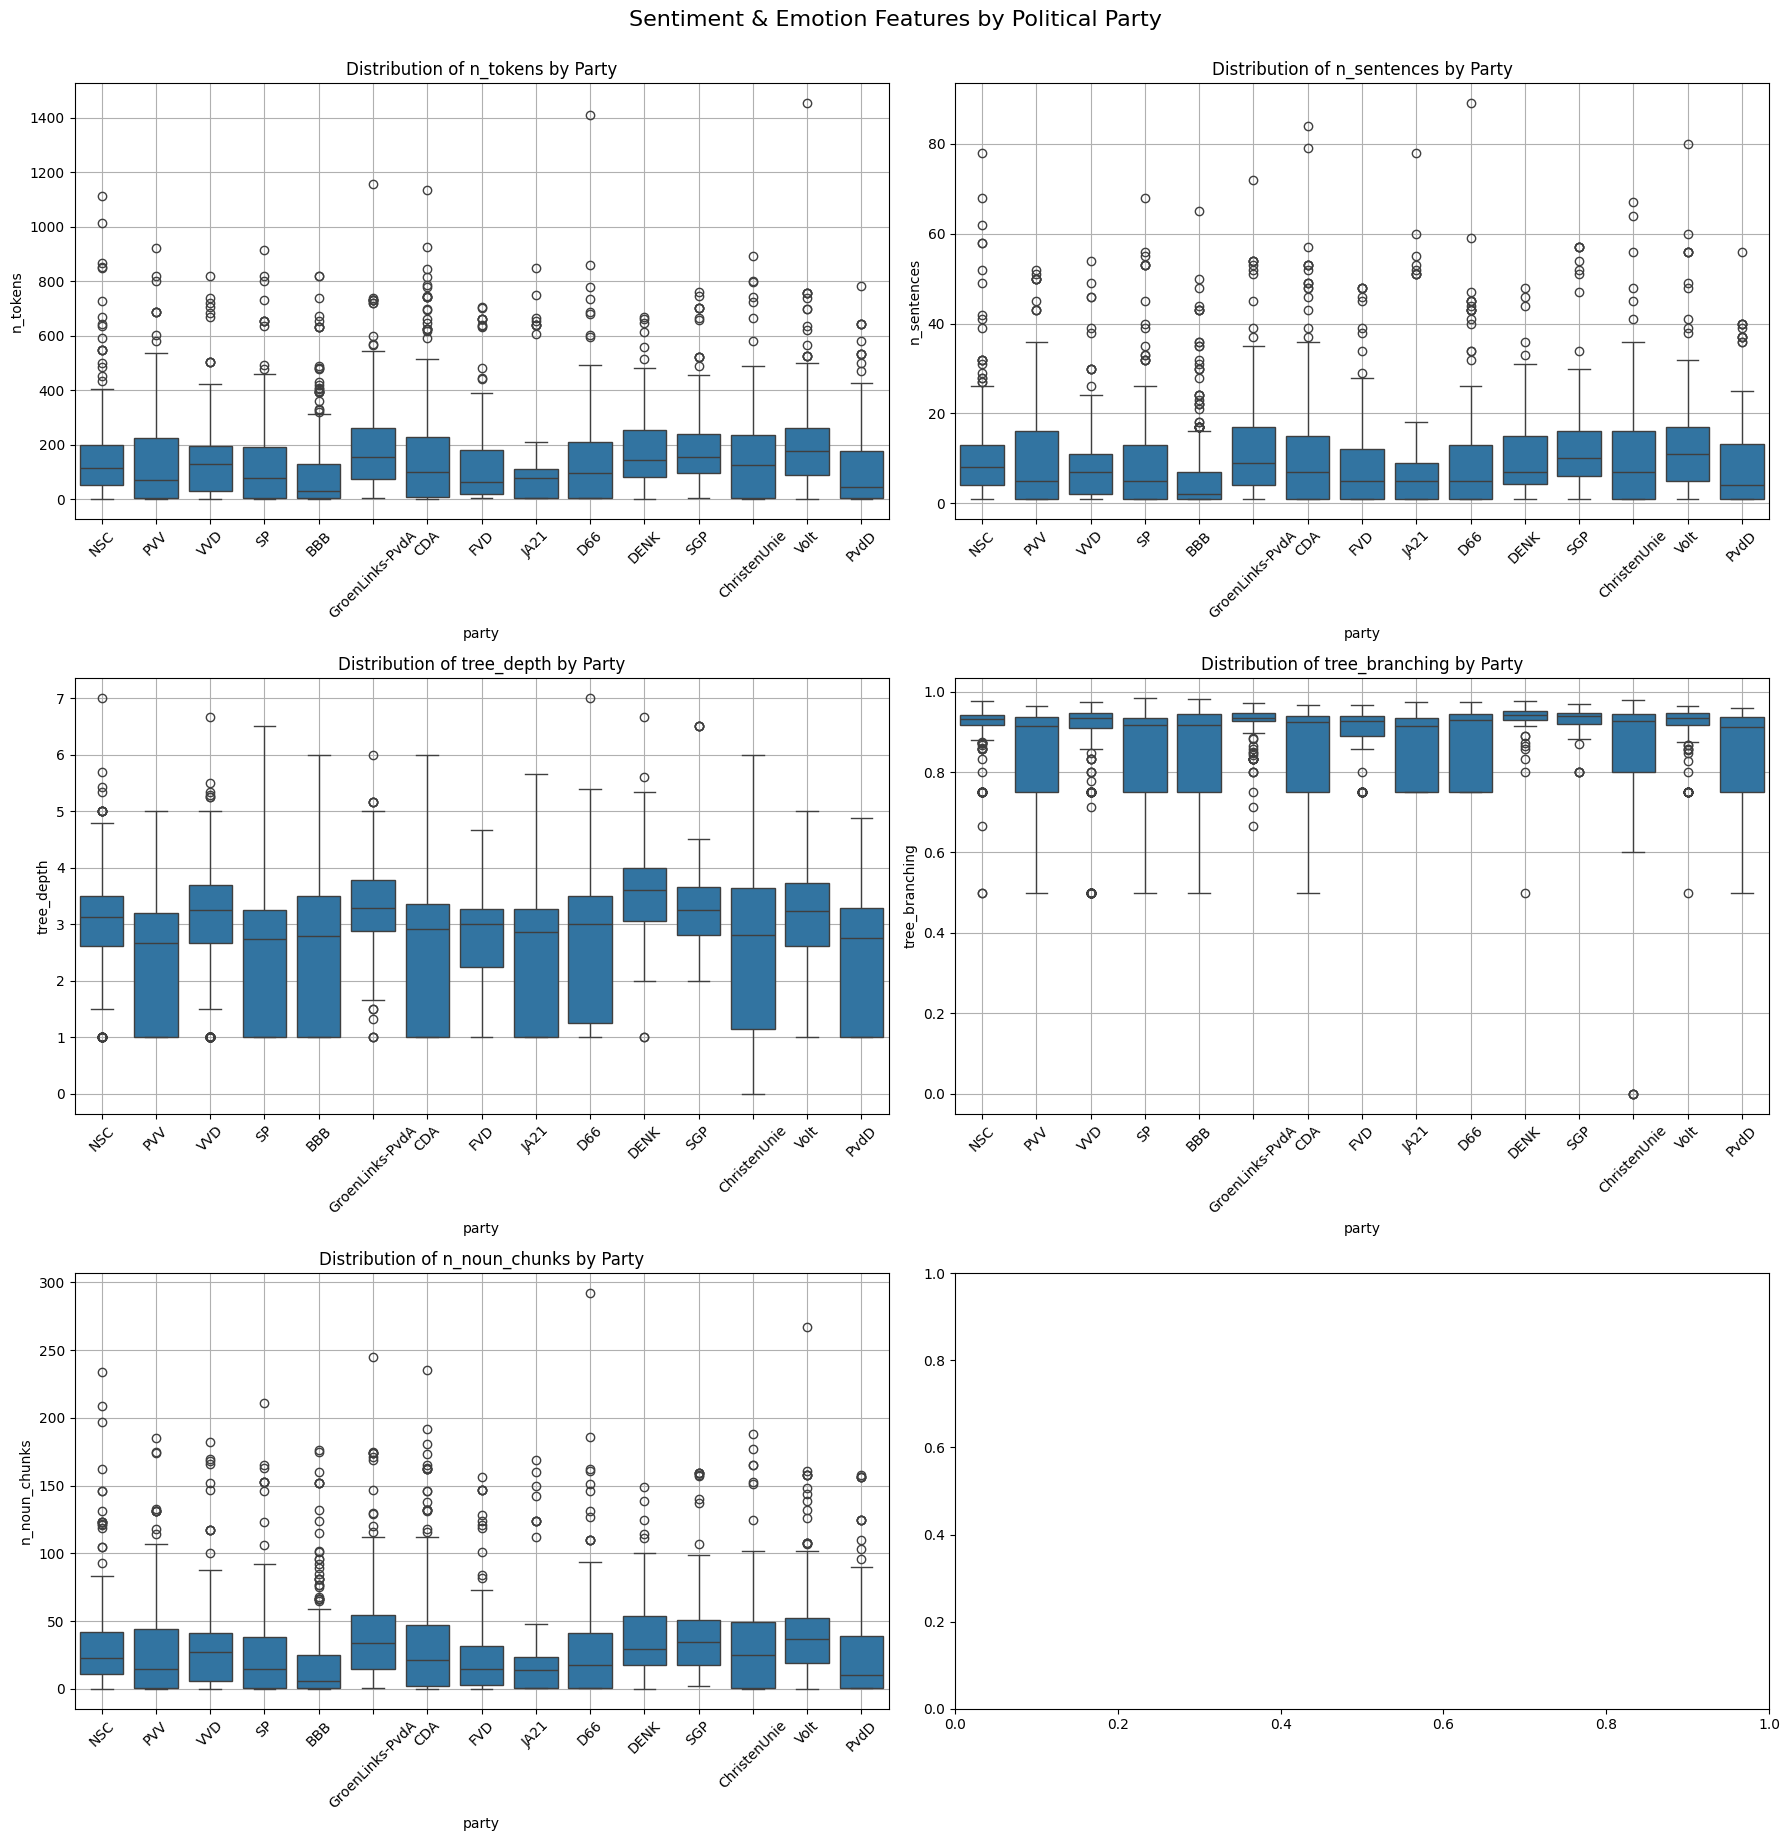

In [24]:
features = [
"n_tokens", "n_sentences", "tree_depth", "tree_branching", "n_noun_chunks"]

df_filtered = df_merged.dropna(subset=["party"] + features)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
axes = axes.flatten()

for idx, feature in enumerate(features):
    sns.boxplot(data=df_filtered, x="party", y=feature, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {feature} by Party", fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True)

plt.tight_layout()
plt.suptitle("Sentiment & Emotion Features by Political Party", fontsize=16, y=1.02)
plt.show()


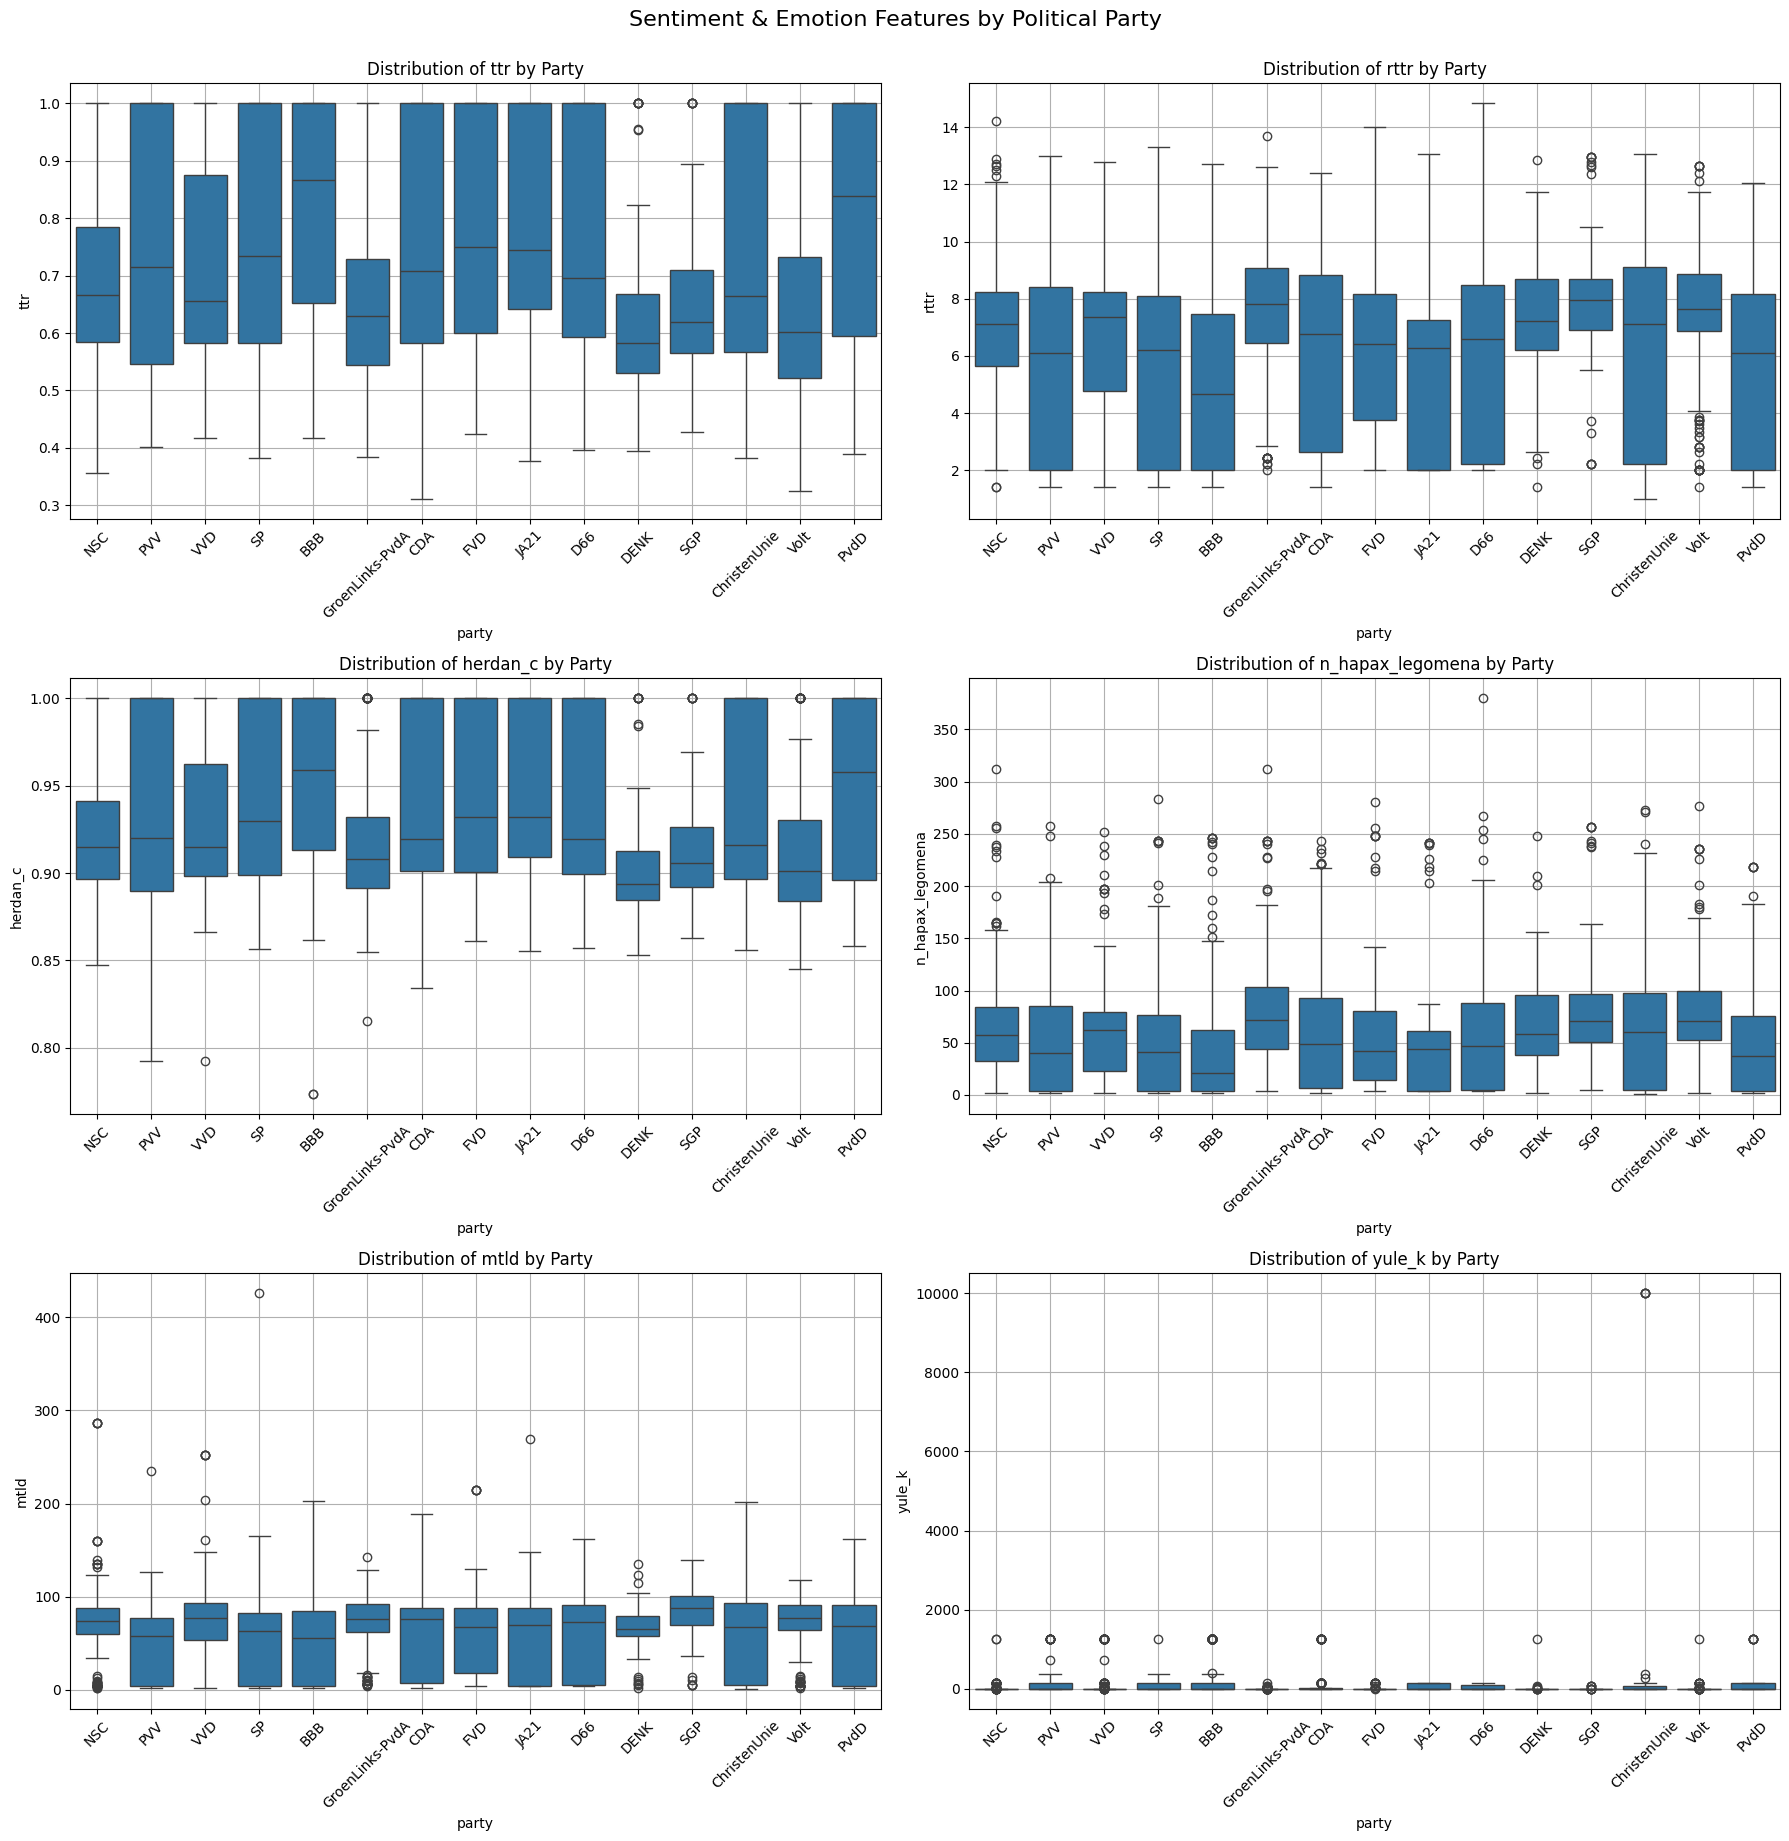

In [25]:
features = ["ttr", "rttr", "herdan_c", "n_hapax_legomena", "mtld", "yule_k"]

df_filtered = df_merged.dropna(subset=["party"] + features)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 18))
axes = axes.flatten()

for idx, feature in enumerate(features):
    sns.boxplot(data=df_filtered, x="party", y=feature, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {feature} by Party", fontsize=12)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True)

plt.tight_layout()
plt.suptitle("Sentiment & Emotion Features by Political Party", fontsize=16, y=1.02)
plt.show()


In [27]:

warnings.filterwarnings("ignore")

df = df_merged.copy()

features = [
    'sentiment_score', 'n_positive_sentiment', 'n_negative_sentiment',
    'avg_valence', 'avg_arousal', 'avg_dominance',
    'avg_intensity_anger', 'avg_intensity_anticipation', 'avg_intensity_disgust',
    'avg_intensity_fear', 'avg_intensity_joy', 'avg_intensity_sadness',
    'avg_intensity_surprise', 'avg_intensity_trust',
    'n_tokens', 'n_sentences', 'tree_depth', 'tree_branching', 'n_noun_chunks',
    'ttr', 'rttr', 'herdan_c', 'n_hapax_legomena', 'mtld', 'yule_k'
]

df_clean = df.dropna(subset=['party'] + features)

results = []
for feature in features:
    groups = [group[feature].dropna().values for name, group in df_clean.groupby('party')]
    stat, p_value = stats.kruskal(*groups)
    results.append({'feature': feature, 'H_statistic': stat, 'p_value': p_value})

results_df = pd.DataFrame(results).sort_values('p_value')
results_df



,feature,H_statistic,p_value
1,n_positive_sentiment,262.063031,9.137980e-48
18,n_noun_chunks,261.991080,9.457239e-48
17,tree_branching,259.336434,3.356492e-47
14,n_tokens,248.730195,5.261082e-45
16,tree_depth,247.355361,1.012264e-44
22,n_hapax_legomena,244.833445,3.360791e-44
20,rttr,240.001947,3.342680e-43
21,herdan_c,238.696323,6.216071e-43
19,ttr,238.615258,6.460136e-43
24,yule_k,237.779313,9.609466e-43


In [29]:
df_merged.to_csv('df_merged.csv')

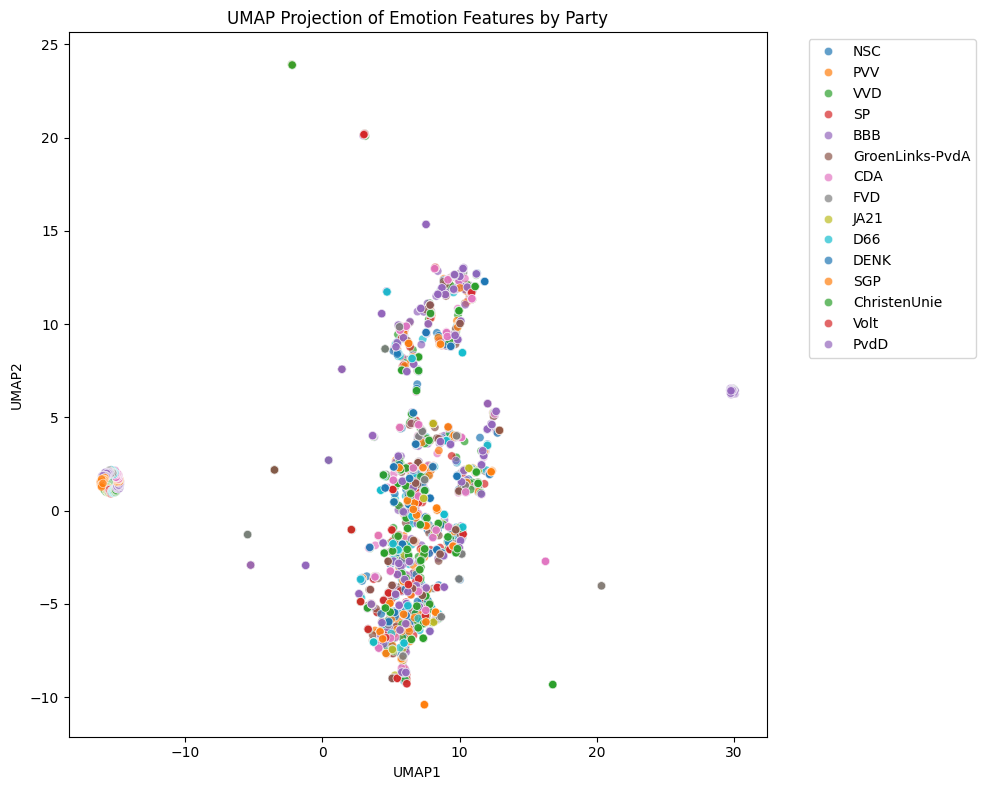

In [52]:
emotion_features = [
    'n_positive_sentiment', 'n_negative_sentiment',
    'avg_valence', 'avg_arousal', 'avg_dominance',
    'avg_intensity_anger', 'avg_intensity_anticipation', 'avg_intensity_disgust',
    'avg_intensity_fear', 'avg_intensity_joy', 'avg_intensity_sadness',
    'avg_intensity_surprise', 'avg_intensity_trust'
    # 'n_tokens', 'n_sentences', 'tree_depth', 'tree_branching','rttr'
]

df_clean = df_merged.dropna(subset=emotion_features + ['party'])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[emotion_features])

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_scaled)


df_clean['UMAP1'] = embedding[:, 0]
df_clean['UMAP2'] = embedding[:, 1]


plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_clean, x='UMAP1', y='UMAP2', hue='party', palette='tab10', alpha=0.7)
plt.title("UMAP Projection of Emotion Features by Party")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


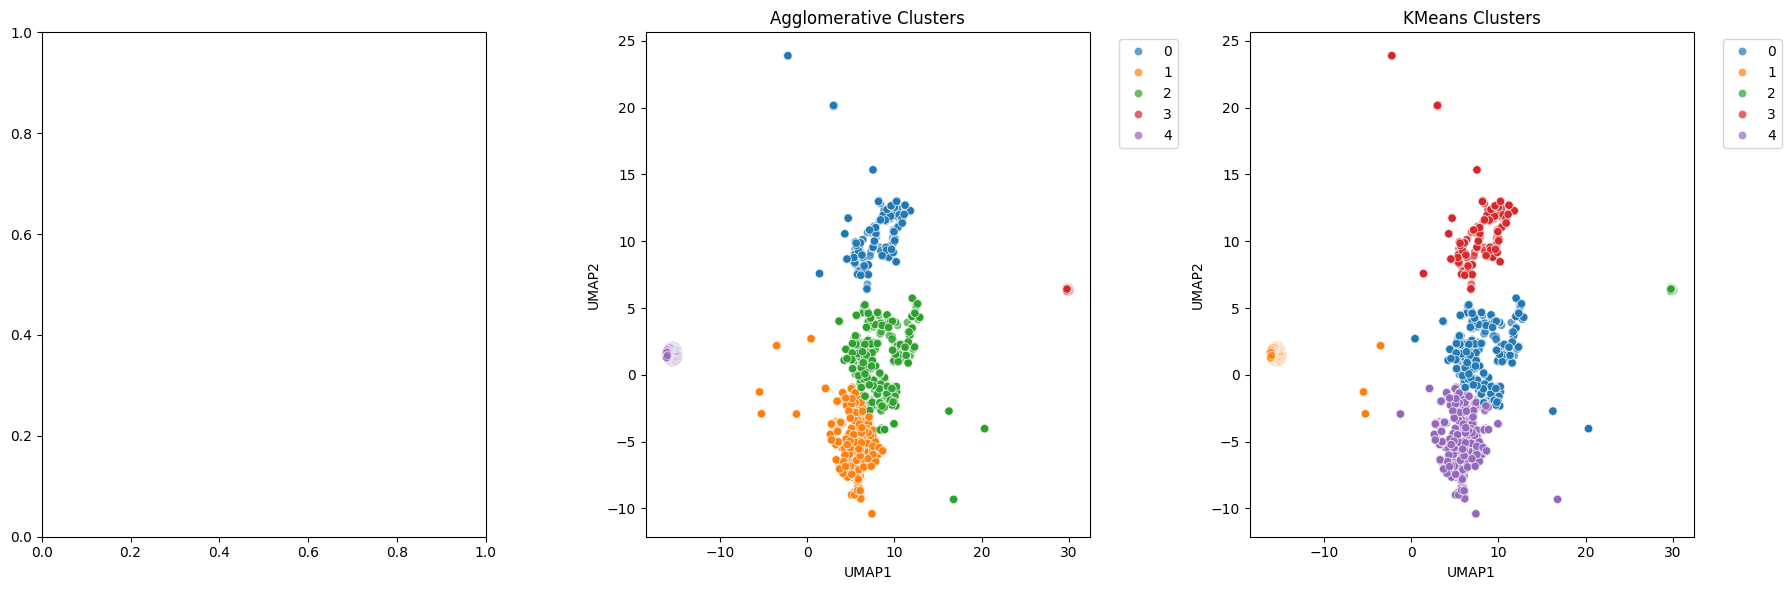

In [54]:
import hdbscan
from sklearn.cluster import AgglomerativeClustering, KMeans

hdb = hdbscan.HDBSCAN(min_cluster_size=15)
df_clean['HDBSCAN_cluster'] = hdb.fit_predict(embedding)

agglo = AgglomerativeClustering(n_clusters=5)
df_clean['Agglomerative_cluster'] = agglo.fit_predict(embedding)

kmeans = KMeans(n_clusters=5, random_state=42)
df_clean['KMeans_cluster'] = kmeans.fit_predict(embedding)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# sns.scatterplot(data=df_clean, x='UMAP1', y='UMAP2', hue='HDBSCAN_cluster', palette='tab10', alpha=0.7, ax=axes[0])
# axes[0].set_title("HDBSCAN Clusters")
# axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.scatterplot(data=df_clean, x='UMAP1', y='UMAP2', hue='Agglomerative_cluster', palette='tab10', alpha=0.7, ax=axes[1])
axes[1].set_title("Agglomerative Clusters")
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.scatterplot(data=df_clean, x='UMAP1', y='UMAP2', hue='KMeans_cluster', palette='tab10', alpha=0.7, ax=axes[2])
axes[2].set_title("KMeans Clusters")
axes[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()



In this case kmeans and agglomerative give the same results

In [55]:
df_clean['KMeans_cluster'].value_counts()


,count
KMeans_cluster,
4,1159
0,1147
3,683
1,528
2,136


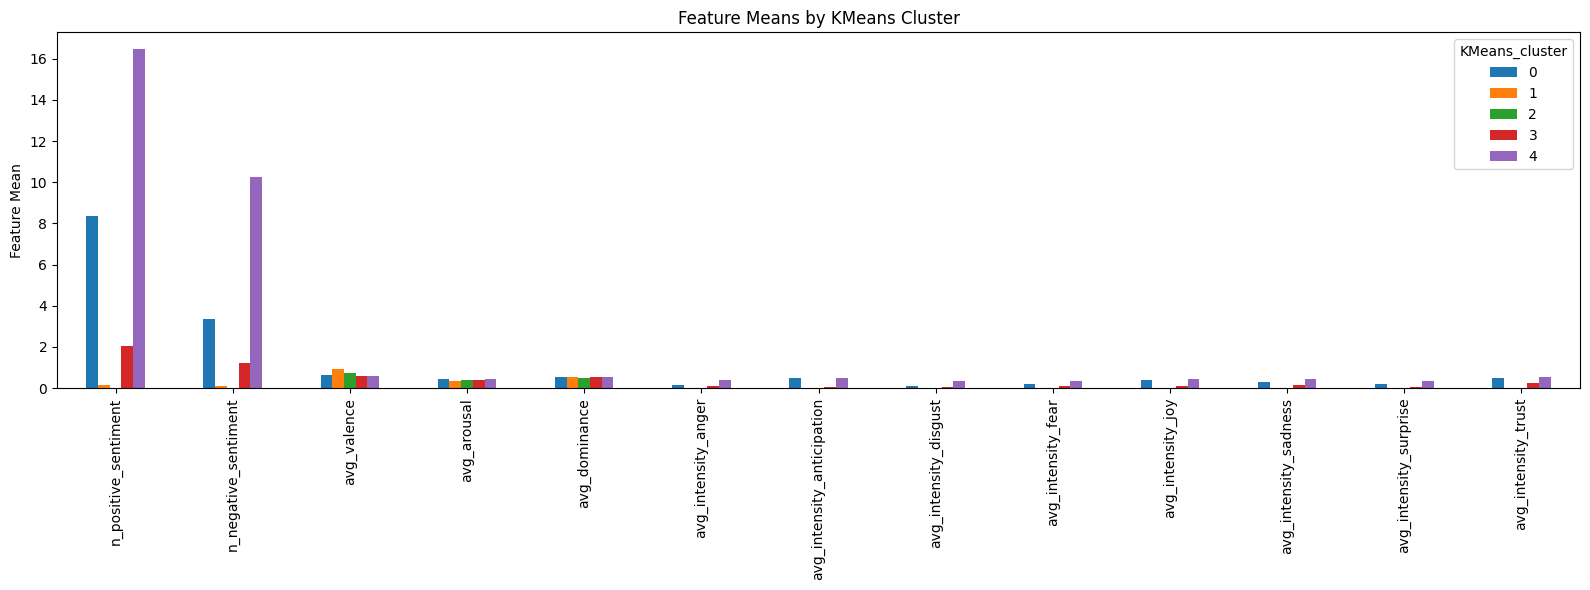

In [56]:
cluster_means = df_clean.groupby('KMeans_cluster')[emotion_features].mean()
cluster_means.T.plot(kind='bar', figsize=(16, 6), title='Feature Means by KMeans Cluster')
plt.ylabel("Feature Mean")
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Normalized Feature Means by Cluster'}>

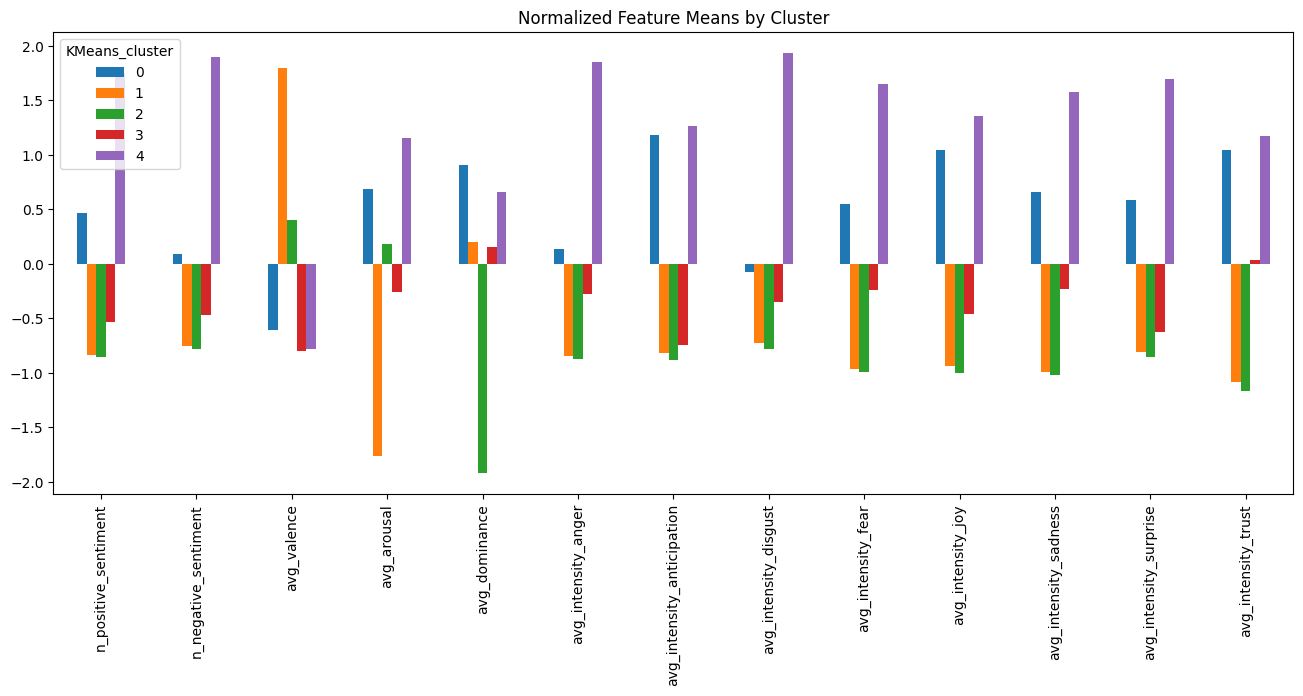

In [57]:
from sklearn.preprocessing import StandardScaler

cluster_means_scaled = pd.DataFrame(
    StandardScaler().fit_transform(cluster_means),
    columns=cluster_means.columns,
    index=cluster_means.index
)
cluster_means_scaled.T.plot(kind='bar', figsize=(16, 6), title='Normalized Feature Means by Cluster')


Text(0.5, 1.0, 'Party Distribution Across KMeans Clusters')

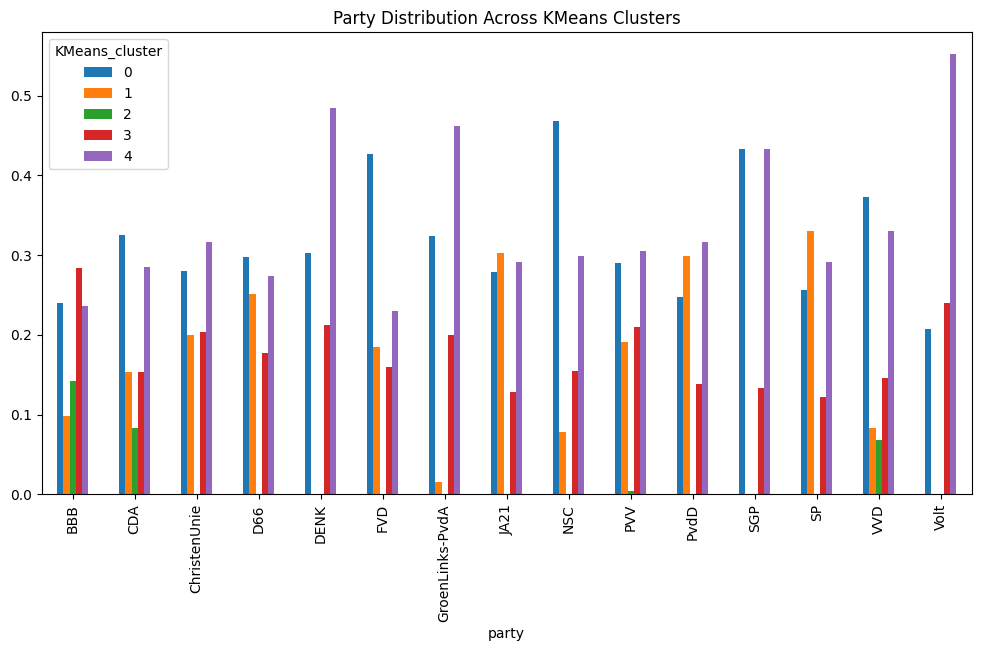

In [58]:
pd.crosstab(df_clean['party'], df_clean['KMeans_cluster'], normalize='index').plot(kind='bar', figsize=(12, 6))
plt.title("Party Distribution Across KMeans Clusters")


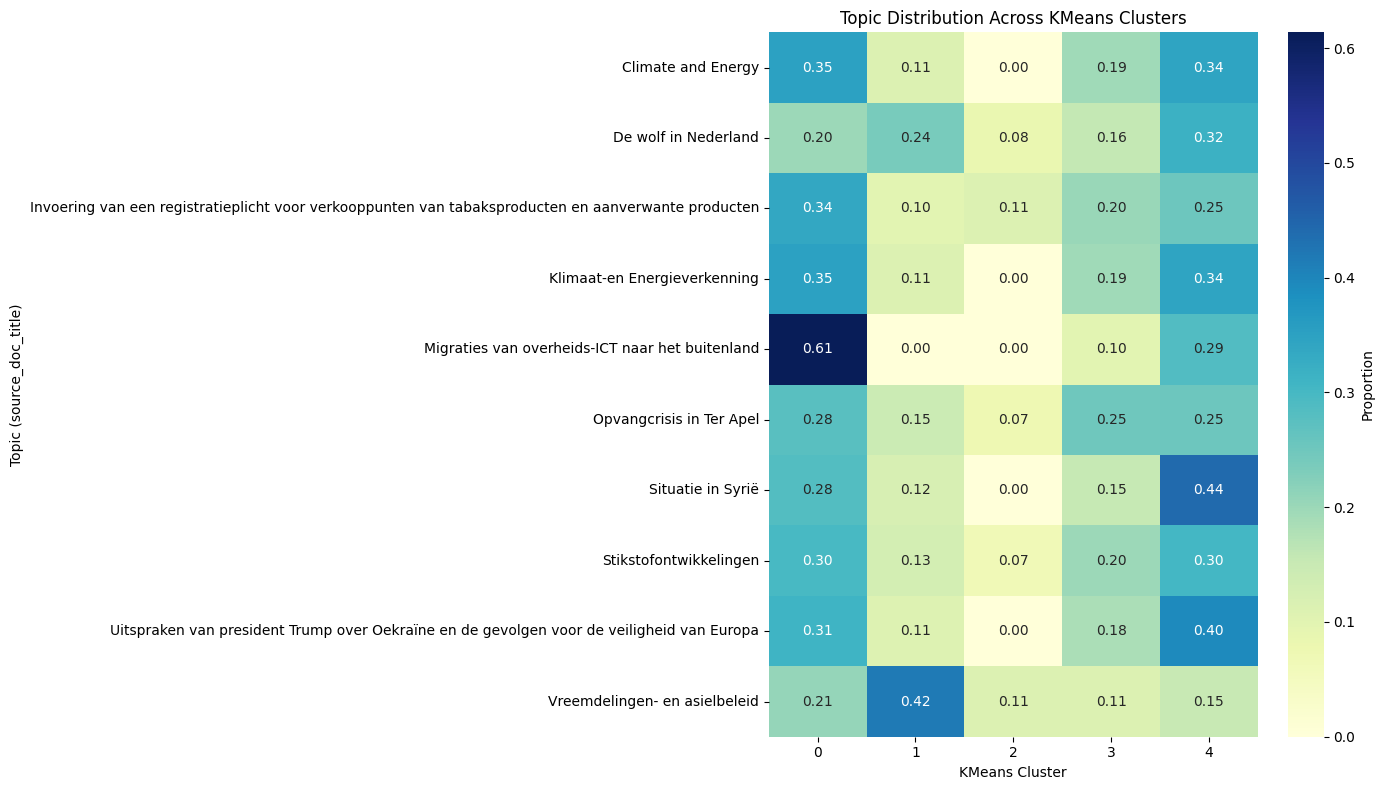

In [59]:
topic_cluster_crosstab = pd.crosstab(df_clean['source_doc_title'], df_clean['KMeans_cluster'], normalize='index')

plt.figure(figsize=(14, 8))
sns.heatmap(topic_cluster_crosstab, cmap='YlGnBu', annot=True, fmt=".2f", cbar_kws={'label': 'Proportion'})
plt.title("Topic Distribution Across KMeans Clusters")
plt.xlabel("KMeans Cluster")
plt.ylabel("Topic (source_doc_title)")
plt.tight_layout()
plt.show()
